In [1]:
from datetime import datetime, timezone, timedelta
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
import xarray as xr
sys.path.append('../sdpm_py_util')
import ocn_functions as ocnfuns
import plotting_functions as pltfuns
import atm_functions as atmfuns
import init_funs as initfuns
import hind_functions as hindfuns
import grid_functions as grdfuns
from get_PFM_info import get_PFM_info
from util_functions import s_coordinate_4
from util_functions import display_timing_info
import observation_functions as obsfuns


#from make_LV4_dotin_and_SLURM import make_LV4_dotin_and_SLURM
from make_LV4_coawst_dotins_dotsb import make_LV4_coawst_dotins_dotsb

from run_slurm_LV4 import run_slurm_LV4


import pickle
import os
import pprint
import subprocess


/home/mspydell/models/PFM_root/PFM/sdpm_py_util/ocn_functions.py:30: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater


In [3]:
yyyymmddhh = '2024101012'
cl,fnout = ocnfuns.get_hind_nc_cmd_list(yyyymmddhh)
print(cl[-2])
print(fnout[-2])

print(len(fnout))

['ncks', '-q', '-D', '0', '-d', 'time,2024-10-11T11:00,2024-10-11T11:30', '-d', 'lon,236.14718692090975,244.3526828277587', '-d', 'lat,28.36036255692185,36.55363973083988', '-v', 'surf_el', 'https://tds.hycom.org/thredds/dodsC/ESPC-D-V02/ssh/2024', '-4', '-O', '/scratch/PHM_Simulations/hycom_data/hycom_hind_2024101012_23_ssh.nc']
/scratch/PHM_Simulations/hycom_data/hycom_hind_2024101012_23_ssh.nc
61


In [1]:
def get_hycom_hind_nc_names(yyyymmddhh):
    # this gets the list of nc files on the hycom server that we need to get.
    t1 = datetime.strptime(yyyymmddhh,'%Y%m%d%H')
    t2 = t1 + timedelta(days=1)
    yyyymmddhh_2 = t2.strftime("%Y%m%d%H")

    yyyy = yyyymmddhh[0:4]
    yyyy2 = yyyymmddhh_2[0:4]

    # for the 1st day we use
    ocn_name = 'https://tds.hycom.org/thredds/dodsC/ESPC-D-V02/'
    #            https://tds.hycom.org/thredds/dodsC/ESPC-D-V02/ssh/2024
    #https://tds.hycom.org/thredds/dodsC/FMRC_ESPC-D-V02_ssh/runs/FMRC_ESPC-D-V02_ssh_RUN_2025-01-08T12:00:00Z

    # and we need the first time of the next day too for boundary conditions
    
    var_names = ['s3z','t3z','u3z','v3z','ssh']

    ncfiles1 = [] # list of urls for the 1st day

    # first do the 1st day
    for bb in var_names:
        ffn = ocn_name + bb + '/' + yyyy 
        ncfiles1.append(ffn)

    return ncfiles1

In [2]:
PFM=get_PFM_info()
print(PFM['fetch_time'])

2024-10-10 12:00:00


In [4]:
yyyymmddhh = '2024101012'
fns = get_hycom_hind_nc_names(yyyymmddhh)
print(fns[0])




https://tds.hycom.org/thredds/dodsC/ESPC-D-V02/s3z/2024


In [2]:
#fns2 = ocnfuns.hycom_to_out(fns)
#print(fns2[0])
yyyymmddhh = PFM['fetch_time'].strftime("%Y%m%d%H")
print(yyyymmddhh)

cmd_list, nc_out = ocnfuns.get_hind_nc_cmd_list(yyyymmddhh)
ret = ocnfuns.get_hycom_hind_data(yyyymmddhh)
print(sum(ret))



[['ncks', '-q', '-D', '0', '-d', 'time,2024-10-10T11:30,2024-10-10T12:30', '-d', 'lon,236.14718692090975,244.3526828277587', '-d', 'lat,28.36036255692185,36.55363973083988', '-v', 'salinity', 'https://tds.hycom.org/thredds/dodsC/ESPC-D-V02/s3z/2024', '-4', '-O', '/scratch/PHM_Simulations/hycom_data/hycom_hind_2024101012_00_s3z.nc'], ['ncks', '-q', '-D', '0', '-d', 'time,2024-10-10T14:30,2024-10-10T15:30', '-d', 'lon,236.14718692090975,244.3526828277587', '-d', 'lat,28.36036255692185,36.55363973083988', '-v', 'salinity', 'https://tds.hycom.org/thredds/dodsC/ESPC-D-V02/s3z/2024', '-4', '-O', '/scratch/PHM_Simulations/hycom_data/hycom_hind_2024101012_03_s3z.nc'], ['ncks', '-q', '-D', '0', '-d', 'time,2024-10-10T17:30,2024-10-10T18:30', '-d', 'lon,236.14718692090975,244.3526828277587', '-d', 'lat,28.36036255692185,36.55363973083988', '-v', 'salinity', 'https://tds.hycom.org/thredds/dodsC/ESPC-D-V02/s3z/2024', '-4', '-O', '/scratch/PHM_Simulations/hycom_data/hycom_hind_2024101012_06_s3z.nc'

In [3]:

ocnfuns.hycom_hind_ncfiles_to_pickle()

PFM = get_PFM_info()
fn_pckl = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ocn_tmp_pckl_file']
os.chdir('../sdpm_py_util')
print('putting the hycom data in ' + fn_pckl + ' on the roms grid...')
cmd_list = ['python','-W','ignore','ocn_functions.py','make_all_tmp_pckl_ocnR_files_1hrzeta',fn_pckl]
os.chdir('../sdpm_py_util')
ret1 = subprocess.run(cmd_list)     
#ocnfuns.make_all_tmp_pckl_ocnR_files(fn_pckl)
os.chdir('../driver')
print('subprocess return code? ' + str(ret1.returncode) +  ' (0=good)')




max and min raw hycom data (iz is top [0] to bottom [39]):
max zeta   =  0.845 m          at  ( it, ilat, ilon)     =  ( 10,  68,  94)
min zeta   = -0.995 m          at  ( it, ilat, ilon)     =  ( 19, 203,   0)
max u      =  0.608 m/s        at  ( it, iz, ilat, ilon) =  (  7,  8,  74,  53)
min u      = -0.580 m/s        at  ( it, iz, ilat, ilon) =  (  8,  2,  41,  76)
max v      =  0.531 m/s        at  ( it, iz, ilat, ilon) =  (  3,  6,  36,  90)
min v      = -0.630 m/s        at  ( it, iz, ilat, ilon) =  (  2,  0, 153,   7)
max temp   = 22.294 C          at  ( it, iz, ilat, ilon) =  (  4,  0,  12,   2)
min temp   =  1.368 C          at  ( it, iz, ilat, ilon) =  (  7, 38, 170,   4)
max dT/dz  =  1.398 C/m        at  ( it, iz, ilat, ilon) =  (  0,  1, 125,  77)
min dT/dz  = -0.137 C/m        at  ( it, iz, ilat, ilon) =  (  4, 13, 121,  56)
max salt   = 34.731 psu        at  ( it, iz, ilat, ilon) =  (  0, 37,  50,  79)
min salt   = 32.586 psu        at  ( it, iz, ilat, ilon) =  (  1, 14

In [4]:
cmd_list = ['python','-W','ignore','ocn_functions.py','print_maxmin_HYrm_pickles']
os.chdir('../sdpm_py_util')
ret1 = subprocess.run(cmd_list)     
os.chdir('../driver')
print('driver_run_forecast_LV1: done with hycom_to_roms_latlon')



max and min of hycom data on ROMS grid (iz is top [0] to bottom [39]):
max zeta   =  0.832 m          at  ( it, ilat, ilon)     =  ( 10,  52, 245)
min zeta   = -0.950 m          at  ( it, ilat, ilon)     =  ( 18, 351, 141)
max urm    =  0.613 m/s        at  ( it, iz, ilat, ilon) =  (  7,  8, 132, 100)
min urm    = -0.655 m/s        at  ( it, iz, ilat, ilon) =  (  8,  0,  23, 150)
max vrm    =  0.508 m/s        at  ( it, iz, ilat, ilon) =  (  2,  7, 350, 112)
min vrm    = -0.672 m/s        at  ( it, iz, ilat, ilon) =  (  2,  0, 366,  12)
max temp   = 22.160 C          at  ( it, iz, ilat, ilon) =  (  4,  0, 209, 191)
min temp   =  1.404 C          at  ( it, iz, ilat, ilon) =  (  7, 38, 216,  11)
max dT/dz  =  1.388 C/m        at  ( it, iz, ilat, ilon) =  (  4,  0,  25, 247)
min dT/dz  = -0.348 C/m        at  ( it, iz, ilat, ilon) =  (  5,  6,   2, 240)
max salt   = 34.731 psu        at  ( it, iz, ilat, ilon) =  (  0, 37,  11, 227)
min salt   = 32.624 psu        at  ( it, iz, ilat, ilon)

In [5]:
print('making the depth pickle file...')
fname_depths = PFM['lv1_forc_dir'] + '/' + PFM['lv1_depth_file']
cmd_list = ['python','-W','ignore','ocn_functions.py','make_rom_depths_1hrzeta',fname_depths]
os.chdir('../sdpm_py_util')
ret6 = subprocess.run(cmd_list)     
os.chdir('../driver')
print('subprocess return code? ' + str(ret6.returncode) +  ' (0=good)')


making the depth pickle file...
making roms depth pickle file /scratch/PHM_Simulations/LV1_Forecast/Forc/roms_tmp_depth_file.pkl...
ROMS depths for IC/BC saved with pickle to /scratch/PHM_Simulations/LV1_Forecast/Forc/roms_tmp_depth_file.pkl
...done makeing depth pickle file.
subprocess return code? 0 (0=good)


In [6]:
ocnIC_pckl = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ocnIC_tmp_pckl_file']
ic_file_out = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ini_file']
bc_file_out = PFM['lv1_forc_dir'] + '/' + PFM['lv1_bc_file']
ocnBC_pckl = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ocnBC_tmp_pckl_file']
fn_atm_out = PFM['lv1_forc_dir'] + '/' + PFM['lv1_atm_file'] # LV1 atm forcing filename


In [8]:
t01=datetime.now()
print('going to save OCN_IC to a pickle file: ' + ocnIC_pckl)
os.chdir('../sdpm_py_util')
cmd_list = ['python','-W','ignore','ocn_functions.py','ocnr_2_ICdict_from_tmppkls',ocnIC_pckl]
ret3 = subprocess.run(cmd_list)     
os.chdir('../driver')
print('OCN IC data saved with pickle, correctly? ' + str(ret3.returncode) + ' (0=yes,1=no)')

print('driver_run_forecast_LV1: done with ocn_r_2_ICdict')
t02 = datetime.now()
print('this took:')
print(t02-t01)
print('\n')

print('making IC file from pickled IC: '+ ic_file_out)
t03 = datetime.now()
cmd_list = ['python','-W','ignore','ocn_functions.py','ocn_roms_IC_dict_to_netcdf_pckl',ocnIC_pckl,ic_file_out]
os.chdir('../sdpm_py_util')
ret4 = subprocess.run(cmd_list)     
os.chdir('../driver')
print('OCN IC nc data saved, correctly? ' + str(ret4.returncode) + ' (0=yes)')


going to save OCN_IC to a pickle file: /scratch/PHM_Simulations/LV1_Forecast/Forc/ocnIC_tmp_pckl_file.pkl
OCN_IC dict saved with pickle
OCN IC data saved with pickle, correctly? 0 (0=yes,1=no)
driver_run_forecast_LV1: done with ocn_r_2_ICdict
this took:
0:00:27.988974


making IC file from pickled IC: /scratch/PHM_Simulations/LV1_Forecast/Forc/LV1_OCEAN_IC.nc
OCN_IC dict loaded with pickle

max and min of data in ROMS IC file (iz is bottom [0] to top [39], note: it is always 0 b/c IC):
max zeta   =  0.340 m          at  ( it, ilat, ilon)     =  (  0,  80,  63)
min zeta   =  0.016 m          at  ( it, ilat, ilon)     =  (  0, 156, 103)
max ubar   =  0.156 m/s        at  ( it, ilat, ilon)     =  (  0, 173, 214)
min ubar   = -0.270 m/s        at  ( it, ilat, ilon)     =  (  0, 309, 136)
max vbar   =  0.233 m/s        at  ( it, ilat, ilon)     =  (  0, 322, 123)
min vbar   = -0.133 m/s        at  ( it, ilat, ilon)     =  (  0, 157, 229)
max u      =  0.502 m/s        at  ( it, iz, ilat, il

In [9]:
print('going to save OCN_BC to a pickle file to:')
t01 = datetime.now()
t04 = datetime.now()
ocnBC_pckl = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ocnBC_tmp_pckl_file']
print(ocnBC_pckl) 
os.chdir('../sdpm_py_util')
cmd_list = ['python','-W','ignore','ocn_functions.py','ocnr_2_BCdict_1hrzeta_from_tmppkls',ocnBC_pckl]
ret4 = subprocess.run(cmd_list)     
os.chdir('../driver')
print('OCN BC data saved with pickle, correctly? ' + str(ret4.returncode) + ' (0=yes)')
    
t02 = datetime.now()
print('this took:')
print(t02-t01)
print('\n')


print('making BC nc file from pickled BC: '+ bc_file_out)
t01 = datetime.now()
cmd_list = ['python','-W','ignore','ocn_functions.py','ocn_roms_BC_dict_to_netcdf_pckl_1hrzeta',ocnBC_pckl,bc_file_out]
os.chdir('../sdpm_py_util')
ret5 = subprocess.run(cmd_list)     
os.chdir('../driver')
print('OCN BC nc data saved, correctly? ' + str(ret5.returncode) + ' (0=yes)')

print('done makeing BC nc file.')



going to save OCN_BC to a pickle file to:
/scratch/PHM_Simulations/LV1_Forecast/Forc/ocnBC_tmp_pckl_file.pkl
loading /scratch/PHM_Simulations/LV1_Forecast/Forc/roms_tmp_depth_file.pkl
OCN_BC dict saved with pickle
OCN BC data saved with pickle, correctly? 0 (0=yes)
this took:
0:00:03.446905


making BC nc file from pickled BC: /scratch/PHM_Simulations/LV1_Forecast/Forc/LV1_OCEAN_BC.nc
OCN_BC dict loaded with pickle

max and min of data in ROMS BC file (iz is bottom [0] to top [39]):
max zeta_north =  0.736 m          at  ( it, ilon)     =  ( 11, 128)
min zeta_north = -0.893 m          at  ( it, ilon)     =  ( 19,  99)
max zeta_south =  0.753 m          at  ( it, ilon)     =  ( 10,  68)
min zeta_south = -0.722 m          at  ( it, ilon)     =  ( 18, 158)
max zeta_west  =  0.764 m          at  ( it, ilat)     =  ( 11, 317)
min zeta_west  = -0.755 m          at  ( it, ilat)     =  ( 19, 221)
max ubar_north =  0.018 m/s        at  ( it, ilon)     =  (  6, 108)
min ubar_north = -0.061 m/s  

In [14]:
import grib2io

#grb2_in = "https://www.ncei.noaa.gov/data/north-american-mesoscale-model/access/analysis/202412/20241231/nam_218_20241231_0000_000.grb2" 
#grb2_in = "https://www.ncei.noaa.gov/thredds/catalog/model-namanl/202412/20241231/nam_218_20241231_0000_000.grb2"
grb2_out = "/scratch/PHM_Simulations/grb2_data/nam_218_20241201_0600_003.grb2"


#ds = xr.open_dataset(grb2_out, engine='cfgrib')

#with open(grb2_out, 'rb') as f:
#    grbs = grib2io.open(f)

g = grib2io.open(grb2_out)

print(g)

#strt = 0
#g.seek(strt)
#print('GRIB2 file poistion: ',g.tell())
#msgs = g.read(500)
#print('Number of messages read: ',len(msgs))
#for msg in msgs:
#    print(msg)

#for a in np.arange(0,1):
#print(g['LWRAD'])

# the variables and levels we need
vars=['PRMSL','RH','TMP','UGRD','VGRD','APCP','DSWRF','USWRF','DLWRF','ULWRF']
lev =['mean sea level','2 m above ground','2 m above ground','10 m above ground','10 m above ground','surface','surface','surface','surface','surface']

apcp = g.select(shortName='APCP',level='surface')[0]
print('\nprinting apcp')
#print(g.select(shortName='APCP',level='surface'))
print(apcp)
print(apcp.validDate,type(apcp.validDate))
print(apcp.duration,type(apcp.duration))
# note, this is not a regular grid. It is on the native grid.

#print(lats[:,0])
#print(lons[0,:])

tmp = g.select(shortName='TMP',level='2 m above ground')[0]
print('\nprinting tmp')
print(tmp)

lats, lons = tmp.grid()

rh = g.select(shortName='RH',level='2 m above ground')[0]
print('\nprinting rh')
print(rh.data[0:10,0])


pmsl = g.select(shortName='PRMSL',level='mean sea level')[0]
print('\nprinting pmsl')
print(pmsl)
u10 = g.select(shortName='UGRD',level='10 m above ground')
print('\nprinting u10')
print(u10)
#pmsl = g.select(shortName=vars[0])[0]
#print(pmsl)
#pmsl_data = pmsl.data
#print(pmsl_data[0:10,0:10])

closed = False
current_message = 0
messages = 452
mode = rb
name = /scratch/PHM_Simulations/grb2_data/nam_218_20241201_0600_003.grb2
size = 56385621


printing apcp
372:d=2024-12-01 06:00:00:APCP:Total Precipitation (kg m-2):surface:3:00:00
2024-12-01 09:00:00 <class 'datetime.datetime'>
3:00:00 <class 'datetime.timedelta'>

printing tmp
360:d=2024-12-01 06:00:00:TMP:Temperature (K):2 m above ground:3:00:00

printing rh
[95.15517 96.45516 96.05517 94.35516 94.65517 96.65517 98.05517 98.05517
 96.85516 94.55517]

printing pmsl
0:d=2024-12-01 06:00:00:PRMSL:Pressure Reduced to MSL (Pa):mean sea level:3:00:00

printing u10
[Section 0: discipline = 0 - Meteorological Products
Section 1: originatingCenter = 7 - US National Weather Service - NCEP (WMC)
Section 1: originatingSubCenter = 0 - None
Section 1: masterTableInfo = 2 - Version Implemented on 4 November 2003
Section 1: localTableInfo = 1 - Number of local table version used.
Section 1: significanceOfReferenceTime = 1 - Start of Foreca

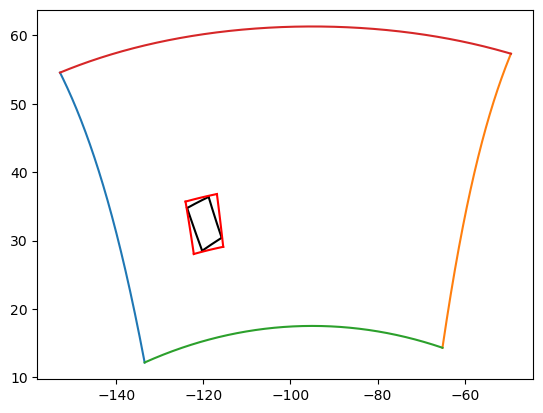

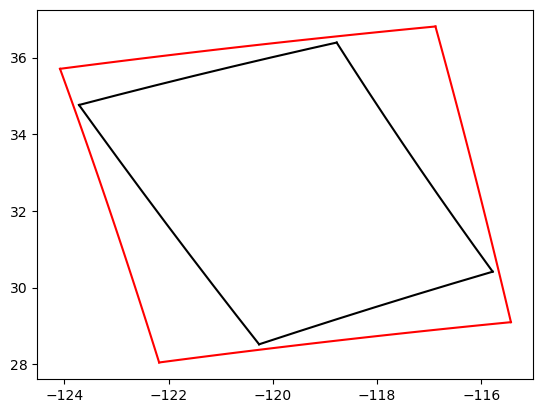

In [81]:
fng = '/scratch/PFM_Simulations/Grids/GRID_SDTJRE_LV1_rx020_hmask.nc'
RMG = grdfuns.roms_grid_to_dict(fng)

fig, ax = plt.subplots()

y1=lats[:,0]
x1=lons[:,0]
y2=lats[:,-1]
x2=lons[:,-1]
y3=lats[0,:]
x3=lons[0,:]
y4=lats[-1,:]
x4=lons[-1,:]

lt_mn = 118
lt_mx = 191
ln_mn = 129
ln_mx = 185
lons2 = lons[lt_mn:lt_mx,ln_mn:ln_mx]
lats2 = lats[lt_mn:lt_mx,ln_mn:ln_mx]

p1=ax.plot(x1,y1)
p1=ax.plot(x2,y2)
p1=ax.plot(x3,y3)
p1=ax.plot(x4,y4)
p1=ax.plot(RMG['lon_rho'][0,:],RMG['lat_rho'][0,:],'k')
p1=ax.plot(RMG['lon_rho'][-1,:],RMG['lat_rho'][-1,:],'k')
p1=ax.plot(RMG['lon_rho'][:,0],RMG['lat_rho'][:,0],'k')
p1=ax.plot(RMG['lon_rho'][:,-1],RMG['lat_rho'][:,-1],'k')

p1=ax.plot(lons2[0,:],lats2[0,:],'r')
p1=ax.plot(lons2[-1,:],lats2[-1,:],'r')
p1=ax.plot(lons2[:,0],lats2[:,0],'r')
p1=ax.plot(lons2[:,-1],lats2[:,-1],'r')

fig, ax = plt.subplots()
p1=ax.plot(RMG['lon_rho'][0,:],RMG['lat_rho'][0,:],'k')
p1=ax.plot(RMG['lon_rho'][-1,:],RMG['lat_rho'][-1,:],'k')
p1=ax.plot(RMG['lon_rho'][:,0],RMG['lat_rho'][:,0],'k')
p1=ax.plot(RMG['lon_rho'][:,-1],RMG['lat_rho'][:,-1],'k')

p1=ax.plot(lons2[0,:],lats2[0,:],'r')
p1=ax.plot(lons2[-1,:],lats2[-1,:],'r')
p1=ax.plot(lons2[:,0],lats2[:,0],'r')
p1=ax.plot(lons2[:,-1],lats2[:,-1],'r')



In [20]:
#tnow = datetime.now()
#hr = tnow.hour

hr = 24
hr = hr % 24
hr2 = hr % 6
hr1 = hr-hr2

print(hr1,hr2)

t1str = '2024120100'
t2str = '2024120200'
l1,l2,l3,l4 = hindfuns.get_nam_hindcast_filelists(t1str,t2str)
print(l3)
print(l4)

#res2 = hindfuns.get_nam_hindcast_grb2s(t1str,t2str)


0 0
[['wget', '-q', '-O', '/scratch/PHM_Simulations/grb2_data/nam_218_20241201_0000_000.grb2', 'https://www.ncei.noaa.gov/data/north-american-mesoscale-model/access/analysis/202412/20241201/nam_218_20241201_0000_000.grb2'], ['wget', '-q', '-O', '/scratch/PHM_Simulations/grb2_data/nam_218_20241201_0000_003.grb2', 'https://www.ncei.noaa.gov/data/north-american-mesoscale-model/access/analysis/202412/20241201/nam_218_20241201_0000_003.grb2'], ['wget', '-q', '-O', '/scratch/PHM_Simulations/grb2_data/nam_218_20241201_0600_000.grb2', 'https://www.ncei.noaa.gov/data/north-american-mesoscale-model/access/analysis/202412/20241201/nam_218_20241201_0600_000.grb2'], ['wget', '-q', '-O', '/scratch/PHM_Simulations/grb2_data/nam_218_20241201_0600_003.grb2', 'https://www.ncei.noaa.gov/data/north-american-mesoscale-model/access/analysis/202412/20241201/nam_218_20241201_0600_003.grb2'], ['wget', '-q', '-O', '/scratch/PHM_Simulations/grb2_data/nam_218_20241201_1200_000.grb2', 'https://www.ncei.noaa.gov/da

In [19]:
tnow = datetime.now()
tref = datetime.strptime('19990101','%Y%m%d')
Dt = tnow - tref
dys = Dt.total_seconds() / (24.0*3600.0)
print(dys)


9519.61517401456


AttributeError: 'float' object has no attribute 'total_days'

In [2]:
fn_in = '/scratch/PHM_Simulations/grb2_data/nam_218_20241201_0000_000.grb2'
fn_out = '/scratch/PHM_Simulations/grb2_data/nam_218_20241201_0000_000.pckl'
hindfuns.grb2_to_pickle(fn_in,fn_out)

ATM grb2 file /scratch/PHM_Simulations/grb2_data/nam_218_20241201_0000_000.grb2 saved to pickle.
